# Example on using OpenAI batch API
The example show how to create a batch of two types of inputs (text and image) to get a text output.

## Read your dataset

In [1]:
import datasets

c:\Users\mosta\anaconda3\envs\detikzify\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = datasets.load_from_disk("sampled_dataset_idx_sorted")

In [3]:
ds

Dataset({
    features: ['caption', 'code', 'image', 'pdf', 'uri', 'origin', 'date', 'idx'],
    num_rows: 500
})

## Create the batch file

In [12]:
# Images are made available to the model in two main ways: by passing a link to the image or by passing the base64 encoded image directly in the request.

import base64
from io import BytesIO
from PIL import Image

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Function to encode the image from PIL object
def encode_image_from_pil(pil_image):
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # Save as JPEG or appropriate format
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [13]:
system_prompt = "your system prompt"

In [14]:
# The base template that will be used for each request(line) in the batch file.
# make sure your mode is supported
# make sure to select the suitable endpoint (url) (completions or embeddings)
# make sure to include all the required parameters in the body field for each request 
# custom_id will hold the sample index from the dataset for each request. This will help you track errors and resubmit failed samples in a separate batch without confusion.
import copy
base_template_dic = {
    "custom_id": None,
    "method": "POST",
    "url": "/v1/chat/completions",
    "body": {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "system",
                "content": None,
            },
            {
                "role": "user",
                "content": None,
            }
        ],
        "max_tokens": 2048,
        "temperature": 0.1
    }
}


In [15]:
base_template_dic

{'custom_id': None,
 'method': 'POST',
 'url': '/v1/chat/completions',
 'body': {'model': 'gpt-4o',
  'messages': [{'role': 'system', 'content': None},
   {'role': 'user', 'content': None}],
  'max_tokens': 2048,
  'temperature': 0.1}}

In [16]:
# Always use deepcopy to make multiple instances of the base dictionary.
# because when you assign a dictionary to a new variable in Python, it is not copied. Instead, the new variable references the same dictionary object in memory. This means that changes made through either variable will affect the same dictionary.
test_template = copy.deepcopy(base_template_dic)

In [18]:
test_template['custom_id'] = "request-1"
test_template['body']['messages'][0]['content'] = system_prompt
test_template['body']['messages'][1]['content'] = "this is the user input"
test_template

{'custom_id': 'request-1',
 'method': 'POST',
 'url': '/v1/chat/completions',
 'body': {'model': 'gpt-4o',
  'messages': [{'role': 'system', 'content': 'your system prompt'},
   {'role': 'user', 'content': 'this is the user input'}],
  'max_tokens': 2048,
  'temperature': 0.1}}

In [20]:
def generate_user_content(code,image):
    user_input = f'''Here is the tikz code for the provided image:\n{code}\n'''
    user_content_code = {
                "type": "text",
                "text": user_input,
            }

    base64_image = encode_image_from_pil(image)
    user_content_image = {
                "type": "image_url",
                "image_url": {
                "url":  f"data:image/jpeg;base64,{base64_image}"
                },
            }
    return [user_content_code, user_content_image]

[{'type': 'text',
  'text': 'Here is the tikz code for the provided image:\n\\documentclass[border=3mm,tikz]{standalone}\n%\\documentclass[11pt]{scrartcl}\n\\usepackage{tikz}\n\n\\begin{document}\n\\begin{tikzpicture}\n\t\\draw[thick]\n\t\\foreach \\i in {1,2,...,10} {%\n\t\t[rotate=(\\i-1)*36] \n\t\t(0:2)  arc (0:18:2) {[rounded corners=2pt] -- ++(18: 0.3)  arc (18:36:2.3) } -- ++(36: -0.3) \n\t};\n\\end{tikzpicture}\n\\end{document}\n'},
 {'type': 'image_url',
  'image_url': {'url': ''}}]
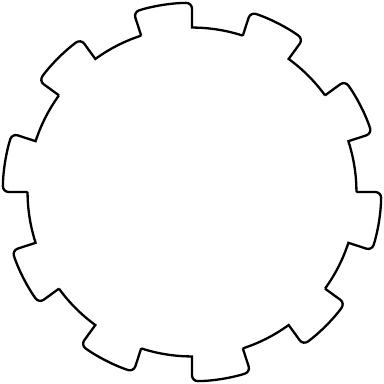

In [21]:
generate_user_content(ds[0]['code'],ds[0]['image'])

In [22]:
# generate the requests for 50 samples (a batch of 50 samples)
batch_result = []
for i in range(50):
    temp_template = copy.deepcopy(base_template_dic)
    temp_template['custom_id'] = f"request-{i}"
    temp_template['body']['messages'][0]['content'] = system_prompt
    temp_template['body']['messages'][1]['content'] = generate_user_content(ds[i]['code'],ds[i]['image'])
    batch_result.append(temp_template)

[{'custom_id': 'request-0',
  'method': 'POST',
  'url': '/v1/chat/completions',
  'body': {'model': 'gpt-4o',
   'messages': [{'role': 'system', 'content': 'your system prompt'},
    {'role': 'user',
     'content': [{'type': 'text',
       'text': 'Here is the tikz code for the provided image:\n\\documentclass[border=3mm,tikz]{standalone}\n%\\documentclass[11pt]{scrartcl}\n\\usepackage{tikz}\n\n\\begin{document}\n\\begin{tikzpicture}\n\t\\draw[thick]\n\t\\foreach \\i in {1,2,...,10} {%\n\t\t[rotate=(\\i-1)*36] \n\t\t(0:2)  arc (0:18:2) {[rounded corners=2pt] -- ++(18: 0.3)  arc (18:36:2.3) } -- ++(36: -0.3) \n\t};\n\\end{tikzpicture}\n\\end{document}\n'},
      {'type': 'image_url',
       'image_url': {'url': ''}}]}],
   'max_tokens': 2048,
   'temperature': 0.1}},
 {'custom_id': 'request-1',
  'method': 'POST',
  'url': '/v1/chat/completions',
  'body': {'model': 'gpt-4o',
   'messages': [{'role': 'system', 'content': 'your system prompt'},
    {'role': 'user',
     'content': [{'t
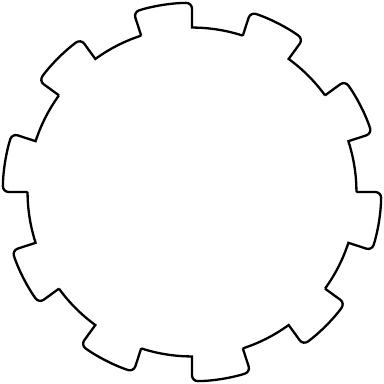
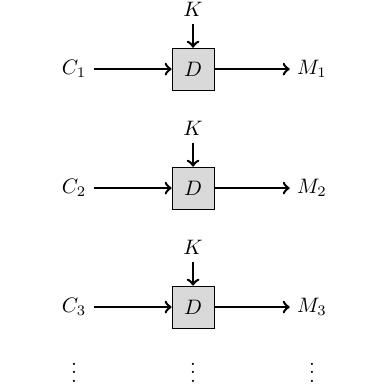
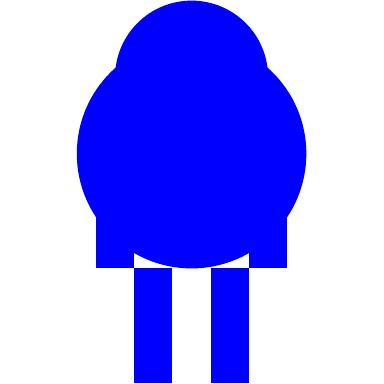
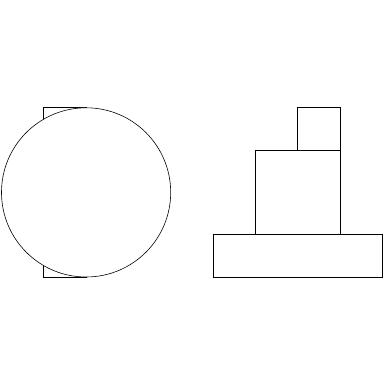
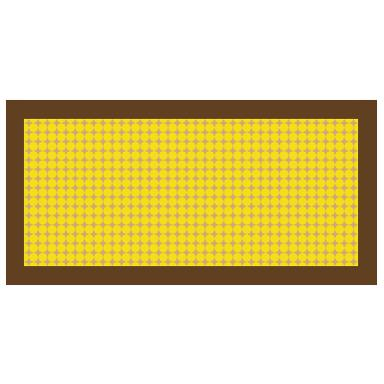
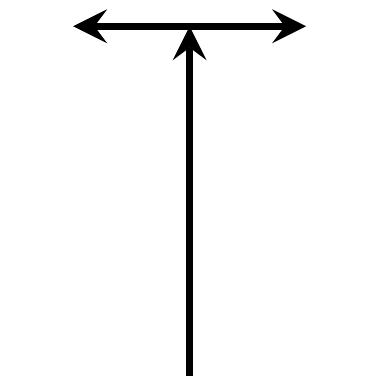
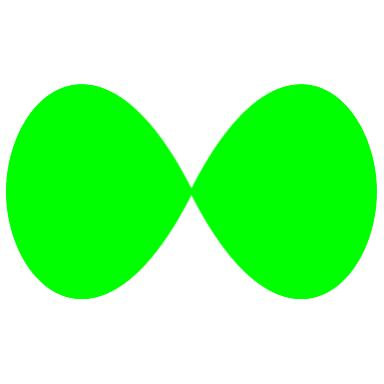
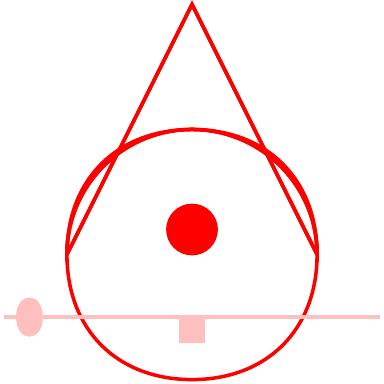
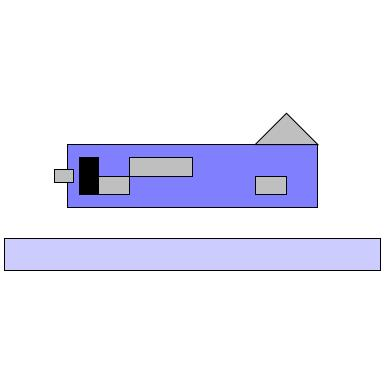
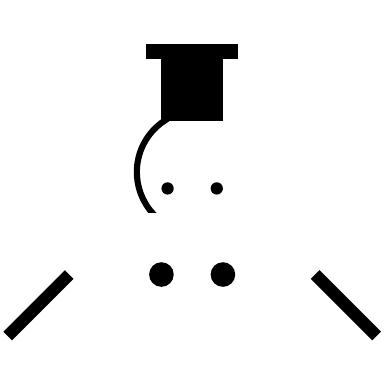
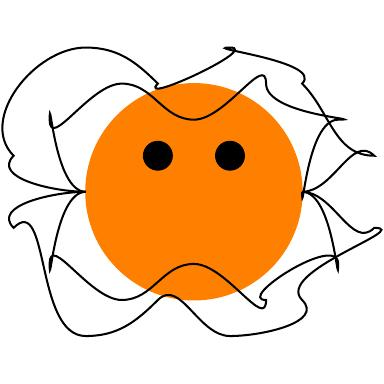
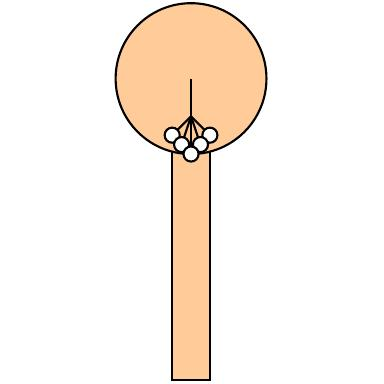
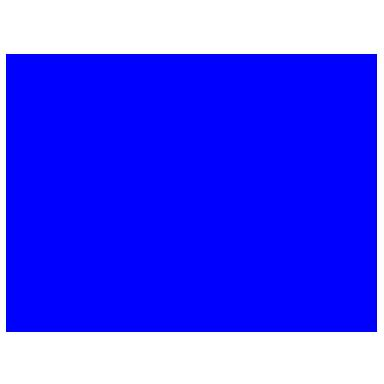
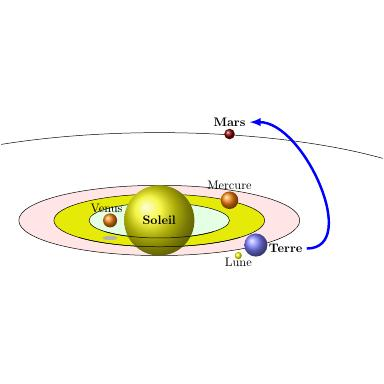
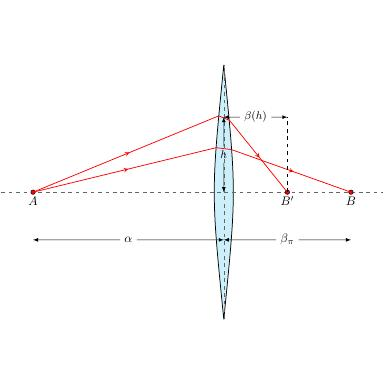
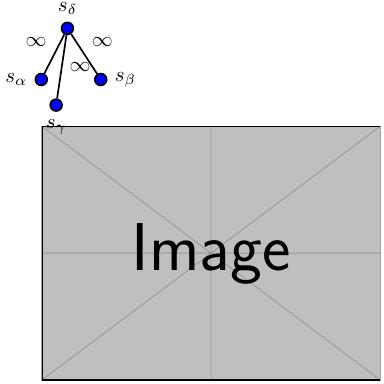
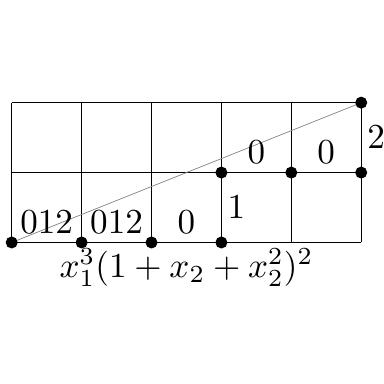
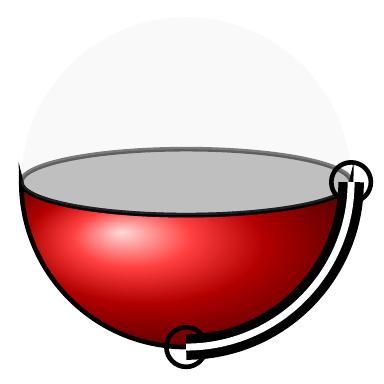
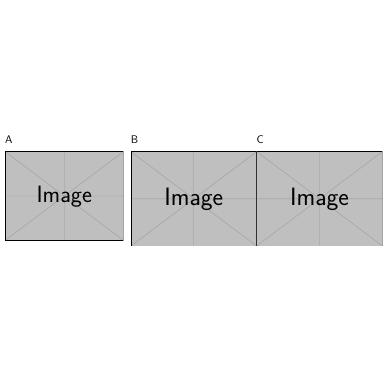
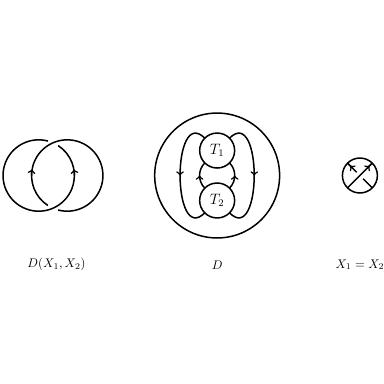
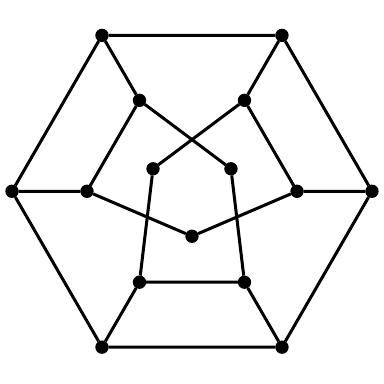
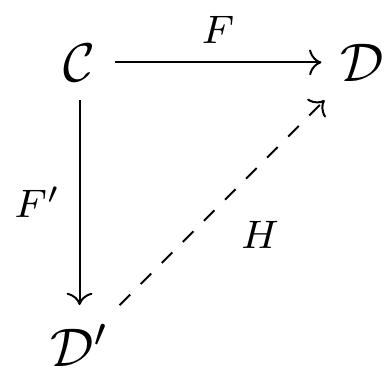
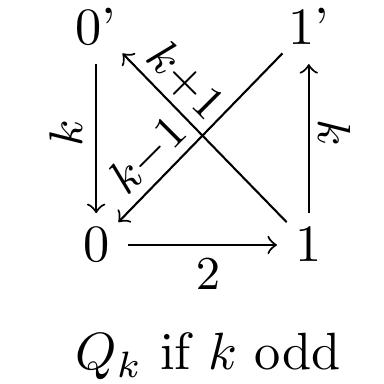
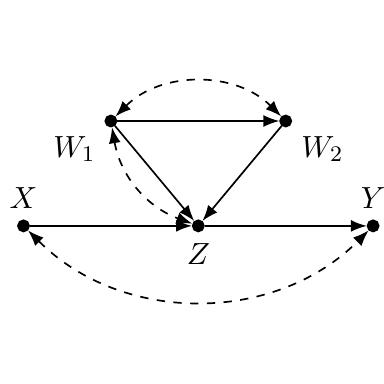
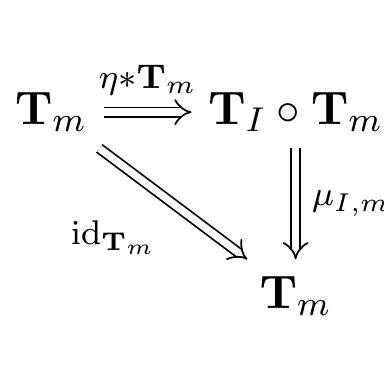
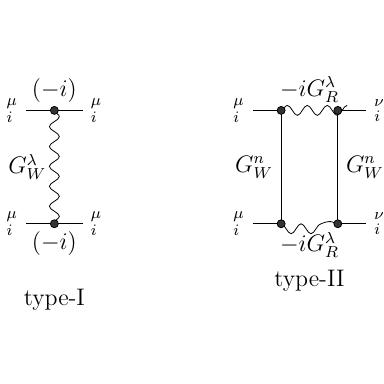
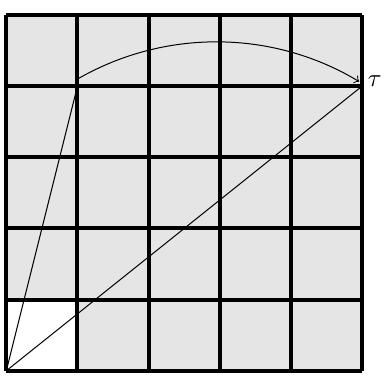
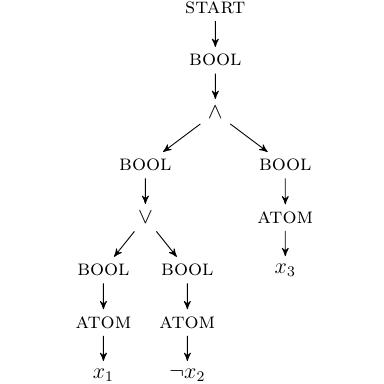
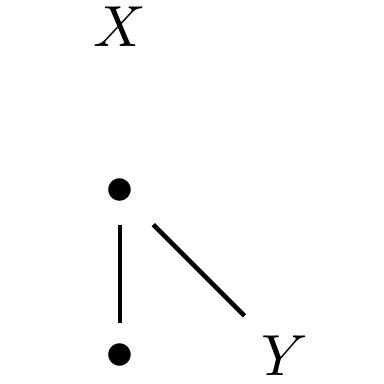
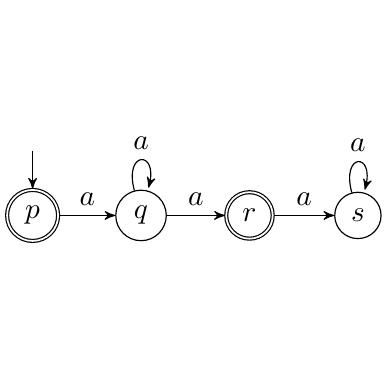
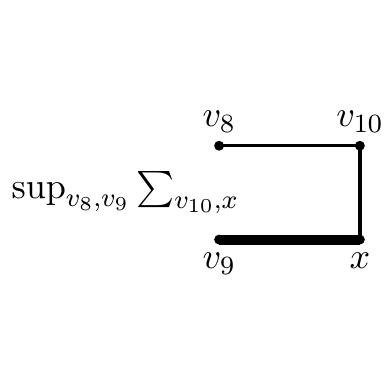
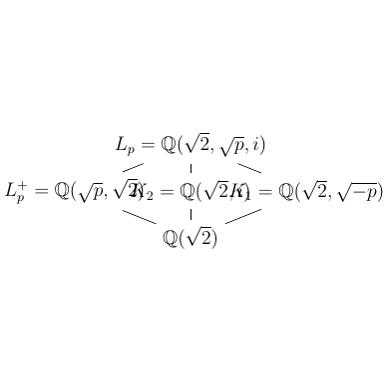
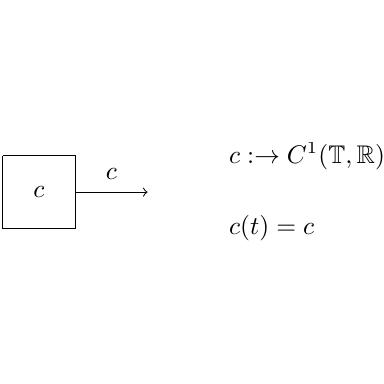
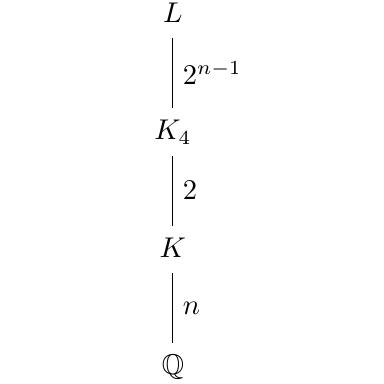
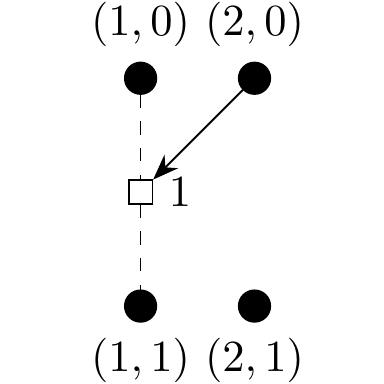
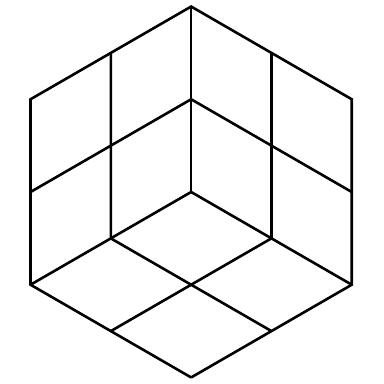
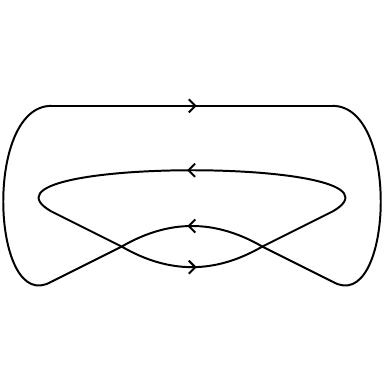
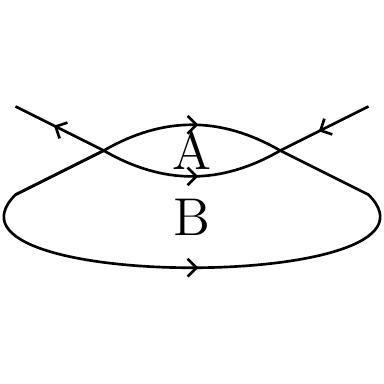
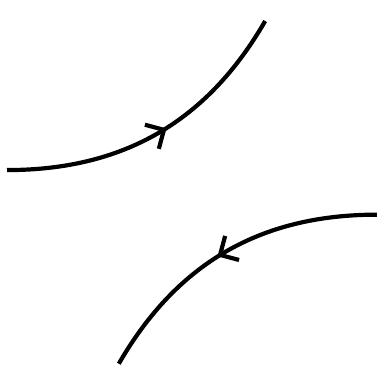
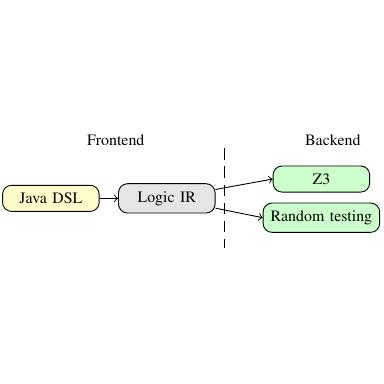
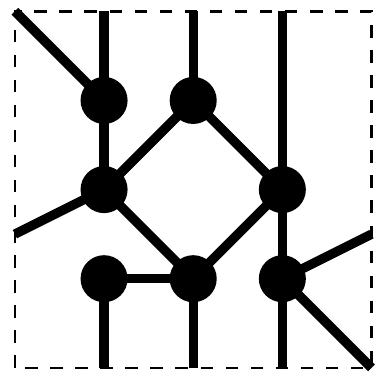
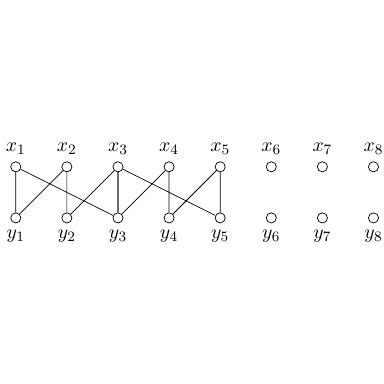
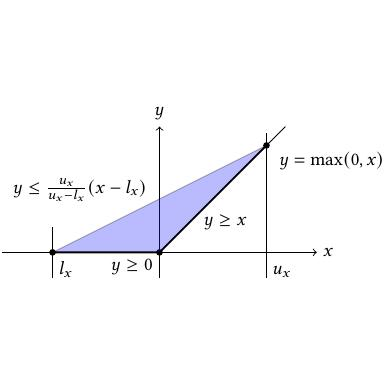
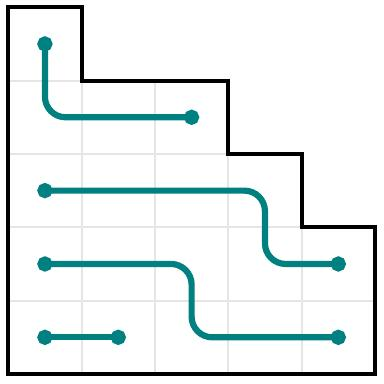
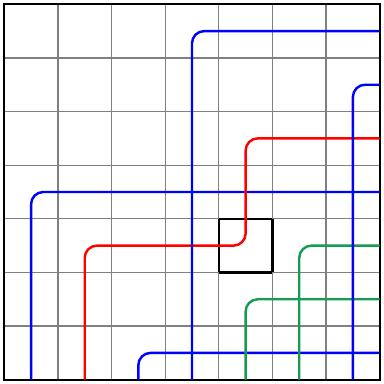
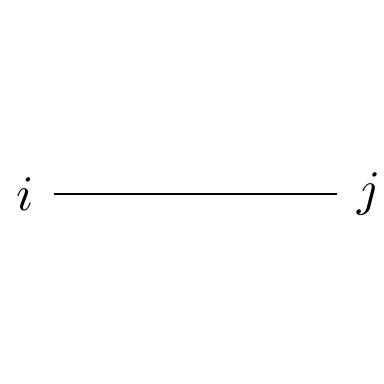
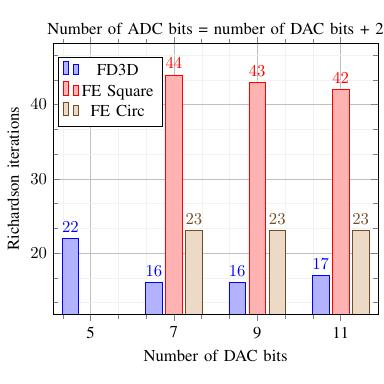
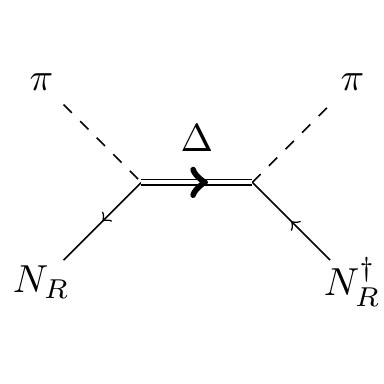
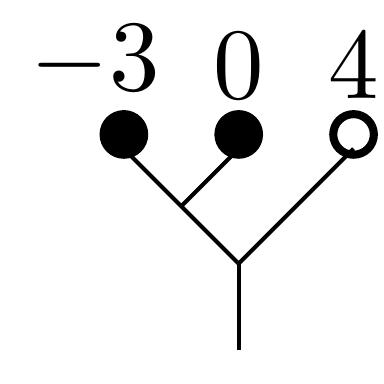
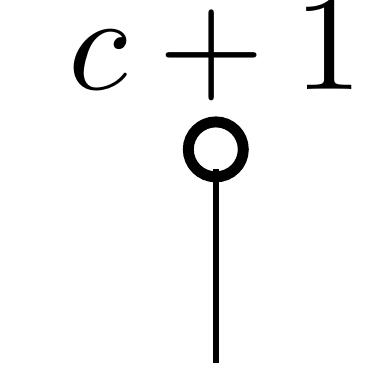

In [23]:
batch_result

In [24]:
len(batch_result)

50

In [ ]:
# save as jsonl file
import json
file_path = "batch_file.jsonl"
with open(file_path, 'w') as f:
    for entry in batch_result:
        json.dump(entry, f)
        f.write('\n')

## Upload batch file and submit a batch requset

In [ ]:
api_key = "your api key"
from openai import OpenAI
client = OpenAI(
    # This is the default and can be omitted
    api_key=api_key,
)

In [ ]:
batch_file_path = "batch_file.jsonl"

In [ ]:
#Upload files to Batch API
batch_input_file = client.files.create(
  file=open(batch_file_path, "rb"),
  purpose="batch"
)

In [ ]:
batch_input_file.id

In [25]:
#submit the Batch request
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "batch file for exprement 1 -- contains from index 0 to 10k -- temp 0.1 -- model gpt-4o"
    }
)

In [26]:
#check the status of the batch
batch_id = ""
client.batches.retrieve(batch_id)

## Download the resutls
After completion, you will find a key called "output_file_id" in the output of the client.batches.retrieve(batch_id) function. You can use this ID to download the batch response.

Alternatively, you can check the Batches Dashboard at: https://platform.openai.com/batches


In [ ]:
output_file_id = "file-xxxxxxxxxxxxxxxx"
file_response = client.files.content(output_file_id)
print(file_response.text)

In [ ]:
# save output file
file_path = "output.jsonl"
with open(file_path, 'w') as file:
    file.write(file_response.text + '\n')


In [27]:
# read file as dataframe
import pandas as pd
data = pd.read_json(file_path, lines=True)